# Time Series Forecasting Using LSTM Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Define file path
file_path = "/Users/elbethelzewdie/Downloads/portfolio-optimization/portfolio-optimization/data/raw/financial_data.csv"

# Load CSV into DataFrame
df = pd.read_csv(file_path, parse_dates=["Date"])

## Prepare Data for Modeling

##### Filtering out the scaled Tesla data

In [9]:
# Filter Tesla scaled data only
tesla_df = df[df["Ticker"] == "TSLA"].copy()

WINDOW_SIZE = 60

# Sort chronologically
tesla_df = tesla_df.sort_values("Date").reset_index(drop=True)

print(f"Tesla dataset loaded with {tesla_df.shape[0]} rows")
print(f"Date range from {tesla_df['Date'].min()} to {tesla_df['Date'].max()}")


Tesla dataset loaded with 2775 rows
Date range from 2015-01-02 00:00:00 to 2026-01-14 00:00:00


In [4]:
# =============================================================
# TRAIN/TEST SPLIT
# =============================================================
series = tesla_df.set_index('Date')['Close']
returns = series.pct_change().dropna()

# Split chronologically
split_date = pd.Timestamp('2025-01-01')
train = returns[returns.index < split_date]
test = returns[returns.index >= split_date]


print(f"Training samples: {len(train)} returns")
print(f"Testing samples: {len(test)} returns")
print(f"\nTraining period: {train.index.min()} to {train.index.max()}")
print(f"Testing period: {test.index.min()} to {test.index.max()}")

Training samples: 2515 returns
Testing samples: 259 returns

Training period: 2015-01-05 00:00:00 to 2024-12-31 00:00:00
Testing period: 2025-01-02 00:00:00 to 2026-01-14 00:00:00


In [5]:
# # =============================================================
scaler = MinMaxScaler(feature_range=(-1, 1))
train_scaled = scaler.fit_transform(train.values.reshape(-1,1))


In [10]:
# PREPARE SEQUENCES FOR LSTM
# =============================================================
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    X, y = np.array(X), np.array(y)
    return X, y

X_train, y_train = create_sequences(train_scaled, WINDOW_SIZE)

In [11]:
# Reshape for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")


X_train shape: (2455, 60, 1), y_train shape: (2455,)


In [12]:
# =============================================================
# BUILD LSTM MODEL
# =============================================================
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [14]:
# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0278 - val_loss: 0.0351
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0278 - val_loss: 0.0351
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0278 - val_loss: 0.0351
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0278 - val_loss: 0.0352
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0277 - val_loss: 0.0352
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0277 - val_loss: 0.0351
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0277 - val_loss: 0.0351
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0278 - val_loss: 0.0351
Epoch 9/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0277 - val_loss: 0.0351
Epoch 10/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0277 - val_loss: 0.0351
Epoch 11/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0277 - val_loss: 0.0351
Epoch 12/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

In [16]:
# =============================================================
# PREPARE TEST DATA
# =============================================================
full_data = np.concatenate((train_scaled, scaler.transform(test.values.reshape(-1,1))), axis=0)

X_test, y_test = create_sequences(full_data, WINDOW_SIZE)
X_test = X_test[-len(test):]        # last sequences only (259 samples)
y_test = y_test[-len(test):]        # slice y_test to match X_test length

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_test shape: (259, 60, 1), y_test shape: (259,)


In [17]:
# FORECAST RETURNS
# =============================================================
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled).flatten()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [18]:
# =============================================================
# CONVERT RETURNS FORECAST TO PRICES
# =============================================================
last_train_price = series.loc[train.index[-1]]
price_forecast = [last_train_price]

In [19]:
for r in y_pred:
    price_forecast.append(price_forecast[-1] * (1 + r))

# Align with test index
price_forecast = pd.Series(price_forecast[1:], index=test.index)

In [23]:
# =============================================================
# CONVERT FORECASTED RETURNS TO PRICES (FIXED)
# =============================================================

# Ensure price is a 1D Series (skip if already a Series)
if isinstance(series, pd.DataFrame):
    if "Close" in series.columns:
        price = series["Close"]
    else:
        # fallback: pick first column
        price = series.iloc[:, 0]

price = series.astype(float)

# Ensure train_returns index matches price
train_last_date = train.index[-1]
last_train_price = price.loc[train_last_date].item()  # <- scalar float
price_forecast = [last_train_price]

# Build forecast price from predicted returns
for r in y_pred.flatten():
    price_forecast.append(price_forecast[-1] * (1 + float(r)))

# Drop the initial training price
price_forecast = price_forecast[1:]

# Make test_price match y_pred length
test_price = price.loc[test.index[:len(price_forecast)]]

# Convert forecast list to Series aligned with test_price index
price_forecast = pd.Series(price_forecast, index=test_price.index)



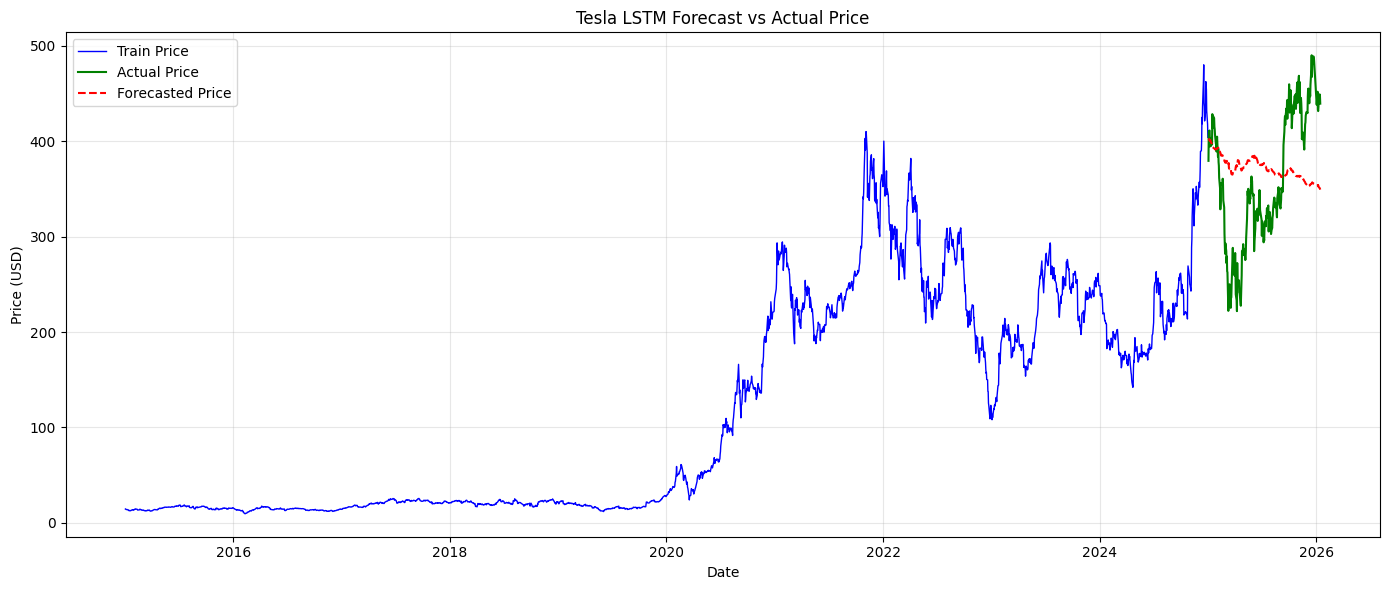

In [24]:
# =============================================================
# VISUALIZE FORECAST VS ACTUAL PRICES
# =============================================================
plt.figure(figsize=(14,6))

# Training prices
plt.plot(price.loc[:train_last_date].index, price.loc[:train_last_date].values, 
         label="Train Price", color='blue', linewidth=1)

# Actual test prices
plt.plot(test_price.index, test_price.values, label="Actual Price", color='green', linewidth=1.5)

# Forecasted prices
plt.plot(price_forecast.index, price_forecast.values, label="Forecasted Price", color='red', linestyle='--', linewidth=1.5)

plt.title(f"Tesla LSTM Forecast vs Actual Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [22]:
# =============================================================
# EVALUATE FORECAST ACCURACY
# =============================================================
# Calculate error metrics
mae = mean_absolute_error(test, price_forecast)
rmse = np.sqrt(mean_squared_error(test, price_forecast))
mape = np.mean(np.abs((test - price_forecast) / test)) * 100

print("Forecast Evaluation Metrics:")
print(f"  Mean Absolute Error (MAE): ${mae:.2f}")
print(f"  Root Mean Squared Error (RMSE): ${rmse:.2f}")
print(f"  Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Forecast Evaluation Metrics:
  Mean Absolute Error (MAE): $371.32
  Root Mean Squared Error (RMSE): $371.50
  Mean Absolute Percentage Error (MAPE): 8601089.16%
